In [ ]:
import pandas as pd
df = pd.read_csv("train.csv")

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
df.shape

(30000, 25)

In [ ]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [ ]:
ews_cols = [ 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month']
df_ews = df[ews_cols].copy()

In [ ]:
df_ews.isnull().sum()

,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0
PAY_5,0
PAY_6,0
BILL_AMT1,0
BILL_AMT2,0
BILL_AMT3,0
BILL_AMT4,0


Add risk trend feature to further generate a weighted behavioural trend. Recent payment delay are considered as stronger signal whereas older delays as weaker influence.

In [ ]:
df_ews["risk_trend_score"] = (
    0.30 * df_ews["PAY_0"] +
    0.25 * df_ews["PAY_2"] +
    0.20 * df_ews["PAY_3"] +
    0.15 * df_ews["PAY_4"] +
    0.10 * df_ews["PAY_5"]
)

In [ ]:
df_ews[["PAY_0","PAY_2","risk_trend_score"]].head()

,PAY_0,PAY_2,risk_trend_score
0,2,2,0.55
1,-1,2,0.20
2,0,0,0.00
3,0,0,0.00
4,-1,0,-0.50


Create a feature to track the fluctuation in the payment behaviour. We use standard deviation across payment history. Stable payer will have low volitality and rapidly changing behaviour will have high volitality.

In [ ]:
pay_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
df_ews["payment_volatility"] = df_ews[pay_cols].std(axis=1)

In [ ]:
df_ews[["risk_trend_score","payment_volatility"]].head(10)

,risk_trend_score,payment_volatility
0,0.55,1.861899
1,0.20,1.224745
2,0.00,0.000000
3,0.00,0.000000
4,-0.50,0.516398
5,0.00,0.000000
6,0.00,0.000000
7,-0.45,0.547723
8,0.40,0.816497
9,-1.90,0.516398


In [ ]:
bill_cols = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
pay_amt_cols = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

df_ews["total_bill"] = df_ews[bill_cols].sum(axis=1)
df_ews["total_paymemt"] = df_ews[pay_amt_cols].sum(axis=1)

Create a Liquidity Stress Feature to look for borrowers who owe more than they repay.

In [ ]:
df_ews["liquidity_stress"] = (
    (df_ews["total_bill"] - df_ews["total_paymemt"])
    / (df_ews["total_bill"].abs() + 1)
)

In [ ]:
df_ews[["risk_trend_score","payment_volatility","liquidity_stress"]].head(10)

,risk_trend_score,payment_volatility,liquidity_stress
0,0.55,1.861899,0.910448
1,0.20,1.224745,0.707167
2,0.00,0.000000,0.891603
3,0.00,0.000000,0.963737
4,-0.50,0.516398,0.459941
5,0.00,0.000000,0.967356
6,0.00,0.000000,0.933656
7,-0.45,0.547723,0.644695
8,0.40,0.816497,0.896309
9,-1.90,0.516398,0.475111


In [ ]:
def minmax(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-6)


In [ ]:
df_ews["trend_norm"] = minmax(df_ews["risk_trend_score"])
df_ews["volatility_norm"] = minmax(df_ews["payment_volatility"])
df_ews["liquidity_norm"] = 1 - minmax(df_ews["liquidity_stress"])


In [ ]:
df_ews["ews_risk_score"] = (
    0.45 * df_ews["trend_norm"] +
    0.30 * df_ews["volatility_norm"] +
    0.25 * df_ews["liquidity_norm"]
)

In [ ]:
print(df_ews[[
    "risk_trend_score",
    "payment_volatility",
    "liquidity_stress",
    "ews_risk_score"
]].head(10))

   risk_trend_score  payment_volatility  liquidity_stress  ews_risk_score
0              0.55            1.861899          0.910448        0.309326
1              0.20            1.224745          0.707167        0.231142
2              0.00            0.000000          0.891603        0.105883
3              0.00            0.000000          0.963737        0.105882
4             -0.50            0.516398          0.459941        0.127762
5              0.00            0.000000          0.967356        0.105882
6              0.00            0.000000          0.933656        0.105882
7             -0.45            0.547723          0.644695        0.133342
8              0.40            0.816497          0.896309        0.203506
9             -1.90            0.516398          0.475111        0.053644


In [ ]:
X = df_ews[[
    "risk_trend_score",
    "payment_volatility",
    "liquidity_stress",
    "ews_risk_score"
]]

y = df_ews["default.payment.next.month"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
print("ROC-AUC", roc_auc_score(y_test, probs))

ROC-AUC 0.7192128216448699


In [ ]:
X1 = df_ews[[
    "risk_trend_score",
    "payment_volatility",
    "liquidity_stress"
]]


In [ ]:
X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.2, random_state=42
)

In [ ]:
model1 = LogisticRegression()
model1.fit(X1_train, y_train)

LogisticRegression()

In [ ]:
probs = model1.predict_proba(X1_test)[:, 1]
print("ROC-AUC", roc_auc_score(y_test, probs))

ROC-AUC 0.7192128216448699


In [ ]:
X2 = df_ews[["ews_risk_score"]]

In [ ]:
X2_train, X2_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42
)

In [ ]:
model2 = LogisticRegression()
model2.fit(X2_train, y_train)

LogisticRegression()

In [ ]:
probs = model2.predict_proba(X2_test)[:, 1]
print("ROC-AUC", roc_auc_score(y_test, probs))

ROC-AUC 0.7058315110859859


In [ ]:
for seed in [1, 10, 25, 42, 100]:
    X_train, X_test, y_train, y_test = train_test_split(
        X1, y, test_size=0.2, random_state=seed
    )
    model = LogisticRegression()
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    print(seed, roc_auc_score(y_test, probs))


1 0.7209644312367881
10 0.723607870338618
25 0.7349812499970146
42 0.7192128216448699
100 0.7348034201474201


In [ ]:
coeff_df = pd.DataFrame({
    "Feature": X1.columns,
    "Coefficient": model.coef_[0]
})

In [ ]:
import numpy as np
coeff_df["Odds_Ratio"] = np.exp(coeff_df["Coefficient"])
print(coeff_df.sort_values(by="Odds_Ratio", ascending=False))


              Feature  Coefficient  Odds_Ratio
1  payment_volatility     0.763301    2.145346
0    risk_trend_score     0.639232    1.895026
2    liquidity_stress     0.000030    1.000030


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
X = df_ews[[
    "risk_trend_score",
    "payment_volatility",
    "liquidity_stress"
]]
y = df_ews["default.payment.next.month"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
probs = gb.predict_proba(X_test)[:,1]
print("Gradient Boosting ROC-AUC:", roc_auc_score(y_test, probs))

Gradient Boosting ROC-AUC: 0.7460718836157958


In [ ]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gb.feature_importances_
})
print(importance_df.sort_values(by="Importance", ascending=False))

              Feature  Importance
0    risk_trend_score    0.802003
1  payment_volatility    0.111283
2    liquidity_stress    0.086714


In [ ]:
pip install shap

In [ ]:
import shap
explainer = shap.Explainer(gb, X_train)
shap_values = explainer(X_test, check_additivity=False)

 98%|===================| 5852/6000 [00:16<00:00]       

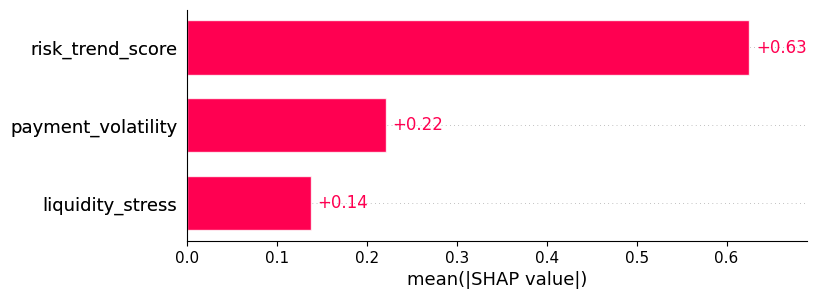

In [ ]:
shap.plots.bar(shap_values)

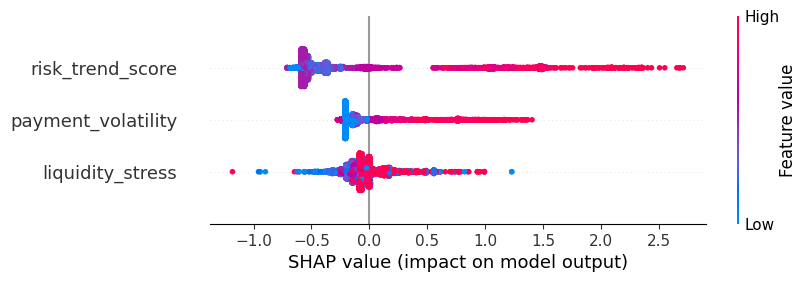

In [ ]:
shap.plots.beeswarm(shap_values)

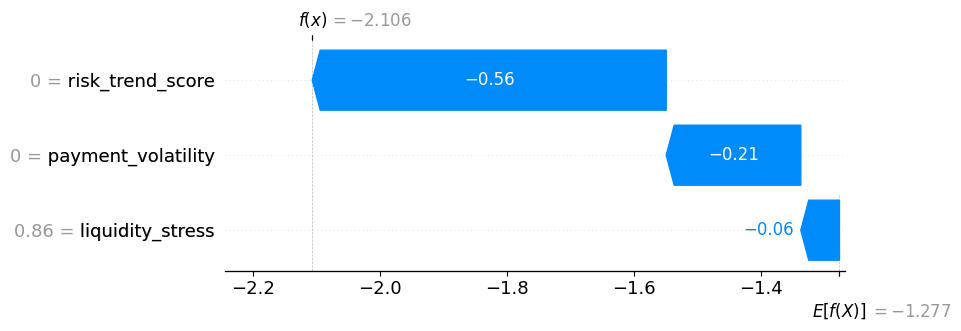

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
seeds = [1, 10, 25, 42, 100]
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )
    gb = GradientBoostingClassifier(random_state=seed)
    gb.fit(X_train, y_train)

    explainer = shap.Explainer(gb, X_train)
    shap_values = explainer(X_test, check_additivity=False)

    mean_shap = np.abs(shap_values.values).mean(axis=0)
    print("\nSeed:",seed)
    print(pd.DataFrame({
        "Feature": X.columns,
        "Mean SHAP": mean_shap
    }).sort_values(by="Mean SHAP", ascending=False))

 98%|===================| 5873/6000 [00:24<00:00]       


Seed: 1
              Feature  Mean SHAP
0    risk_trend_score   0.584287
1  payment_volatility   0.208986
2    liquidity_stress   0.124958

Seed: 10
              Feature  Mean SHAP
0    risk_trend_score   0.658284
1  payment_volatility   0.204196
2    liquidity_stress   0.131047

Seed: 25
              Feature  Mean SHAP
0    risk_trend_score   0.501979
1  payment_volatility   0.212454
2    liquidity_stress   0.120415

Seed: 42
              Feature  Mean SHAP
0    risk_trend_score   0.625380
1  payment_volatility   0.221444
2    liquidity_stress   0.138071

Seed: 100
              Feature  Mean SHAP
0    risk_trend_score   0.520392
1  payment_volatility   0.228801
2    liquidity_stress   0.121487


In [ ]:
df_ews["coverage_1"] = df_ews["PAY_AMT1"] / (df_ews["BILL_AMT1"] + 1)
df_ews["coverage_2"] = df_ews["PAY_AMT2"] / (df_ews["BILL_AMT2"] + 1)
df_ews["coverage_3"] = df_ews["PAY_AMT3"] / (df_ews["BILL_AMT3"] + 1)

In [ ]:
df_ews["liquidity_trend"] = (
    df_ews["coverage_1"] - df_ews["coverage_3"]
)

In [ ]:
df_ews["payment_drop"] = (
    df_ews["PAY_AMT1"] - df_ews["PAY_AMT3"]
)

In [ ]:
df_ews.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,...,liquidity_stress,trend_norm,volatility_norm,liquidity_norm,ews_risk_score,coverage_1,coverage_2,coverage_3,liquidity_trend,payment_drop
0,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,...,0.910448,0.300000,0.581087,5.527915e-07,0.309326,0.000000,0.222043,0.000000,0.000000,0.0
1,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,...,0.707167,0.258823,0.382235,1.807603e-06,0.231142,0.000000,0.579374,0.372717,-0.372717,-1000.0
2,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,...,0.891603,0.235294,0.000000,6.691172e-07,0.105883,0.051915,0.106929,0.073746,-0.021831,518.0
3,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,...,0.963737,0.235294,0.000000,2.238503e-07,0.105882,0.042561,0.041858,0.024345,0.018217,800.0
4,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,...,0.459941,0.176471,0.161165,3.333677e-06,0.127762,0.232072,6.468171,0.279049,-0.046977,-8000.0


In [ ]:
df_ews["liquidity_trend"] = (
    df_ews["coverage_3"] - df_ews["coverage_1"]
)

In [ ]:
X = df_ews[[
    "risk_trend_score",
    "payment_volatility",
    "liquidity_trend",
    "payment_drop"
]].copy()

# Replace infinite values with NaN before processing
X.replace([np.inf, -np.inf], np.nan, inplace=True)

y = df_ews["default.payment.next.month"]

In [ ]:
nan_rows = X.isnull().any(axis=1)
X_cleaned = X[~nan_rows]
y_cleaned = y[~nan_rows]

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

probs = gb.predict_proba(X_test)[:,1]

print("Gradient Boosting ROC-AUC:", roc_auc_score(y_test, probs))

Gradient Boosting ROC-AUC: 0.7552329877685499


In [ ]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gb.feature_importances_
})

print("\nFeature Importance:")
print(importance_df.sort_values(by="Importance", ascending=False))


Feature Importance:
              Feature  Importance
0    risk_trend_score    0.805667
1  payment_volatility    0.117997
2     liquidity_trend    0.040981
3        payment_drop    0.035355


In [ ]:
explainer = shap.Explainer(gb, X_train)
shap_values = explainer(X_test)

mean_shap = np.abs(shap_values.values).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean_SHAP": mean_shap
})

print("\nMean SHAP Values:")
print(shap_df.sort_values(by="Mean_SHAP", ascending=False))


Mean SHAP Values:
              Feature  Mean_SHAP
0    risk_trend_score   0.542690
1  payment_volatility   0.206294
3        payment_drop   0.122148
2     liquidity_trend   0.091740


To check if early warning signal strengthens as event approaches.

In [ ]:
df_ews["risk_m3"] = (
    0.5*df_ews["PAY_6"] +
    0.3*df_ews["PAY_5"] +
    0.2*df_ews["PAY_4"]
)

df_ews["risk_m2"] = (
    0.5*df_ews["PAY_5"] +
    0.3*df_ews["PAY_4"] +
    0.2*df_ews["PAY_3"]
)

df_ews["risk_m1"] = (
    0.5*df_ews["PAY_4"] +
    0.3*df_ews["PAY_3"] +
    0.2*df_ews["PAY_2"]
)

df_ews["risk_current"] = df_ews["risk_trend_score"]

In [ ]:
df_ews.groupby("default.payment.next.month")[[
    "risk_m3",
    "risk_m2",
    "risk_m1",
    "risk_current"
]].mean()

,risk_m3,risk_m2,risk_m1,risk_current
default.payment.next.month,,,,
0,-0.390785,-0.364685,-0.333077,-0.294391
1,0.157324,0.232715,0.327547,0.442405
